<a href="https://colab.research.google.com/github/bulinayas/Deep-deep-learning/blob/main/%5Bseminar%5Dneuron_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png", width=300, height=300></p>

<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

<h2 style="text-align: center;"><b>Один нейрон на PyTorch</b></h3>

В этом ноутбуке мы научимся писать свои нейросети на фреймворке PyTorch, конкретно - рассмотрим, как написать свой нейрон с разными функциями потерь и рассмотрим его работу на конкретных датасетах.

<h3 style="text-align: center;"><b>Компоненты нейросети</b></h3>

Здесь самое время напомнить о том, какие вещи играют принципиальную роль в построении любой ***нейронной сети*** (все их мы задаём *руками*, самостоятельно):  

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количество итераций обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

<h3 style="text-align: center;"><b>Один нейрон на PyTorch</b></h3>

Данные пока что возьмём как и прежде - "яблоки и груши":

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv("/content/drive/MyDrive/Копия apples_pears.csv")

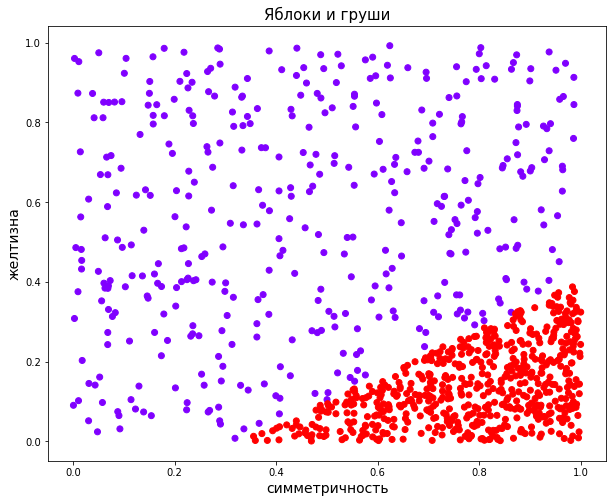

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=data['target'], cmap='rainbow')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

In [4]:
X = data.iloc[:,:2].values  # матрица объекты-признаки
y = data['target'].values.reshape((-1, 1))  # классы (столбец из нулей и единиц)

В модуле torch.nn лежат все необходимые вещи для конструирования нейронок, а в модуле torch.optim лежат все необходимые вещи для выбора метода оптимизации нейросети:

In [ ]:
import torch
from torch.nn import Linear, Sigmoid

Есть **два пути объявления нейросетей** в PyTorch:  
- ***функциональный (`Functional`);***
- ***последовательный (`Sequential`);  ***

Рассмотрим второй путь (он чуть более user-friendly), к первому потом ещё вернёмся, и построим таким способом один нейрон (точно такой же, который мы реализовывали раньше с помощью Numpy):

In [ ]:
num_features = X.shape[1]

neuron = torch.nn.Sequential(
    Linear(num_features, out_features=1),
    Sigmoid()
)

In [ ]:
neuron

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

Пока что мы просто создали объект класса `Sequential`, который состоит из одного линейного слоя размерности (num_features, 1) и последующего применения сигмоиды. Но уже сейчас его можно применить к объекту (тензору), просто веса в начале инициализирутся случайно и при forward_pass'е мы получим какой-то ответ пока что необученного нейрона:

In [ ]:
neuron(torch.FloatTensor([1, 1]).requires_grad_(requires_grad = True))

tensor([0.2731], grad_fn=<SigmoidBackward0>)

Предскажем ещё необученным нейроном:

In [ ]:
proba_pred = neuron(torch.FloatTensor(X).requires_grad_(requires_grad = True))
y_pred = proba_pred > 0.5
type(y_pred)

torch.Tensor

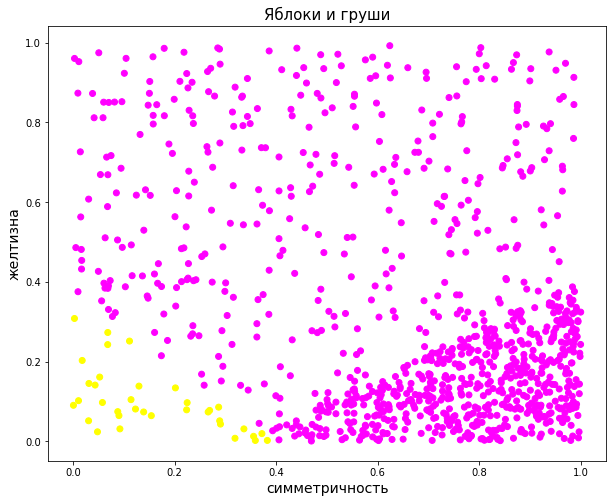

In [ ]:
y_pred = y_pred.data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

Как и ожидалось, ничего полезного. Давайте научим нейрон отличать груши от яблок по их симметричности и желтизне!

Обернём данные в `torch.Tensor`'ы, а тензоры в `torch.Variable`'ы, чтобы можно было вычислять градиенты по весам:

In [ ]:
X = torch.FloatTensor(X).requires_grad_(requires_grad = True)
y = torch.FloatTensor(y)

Код обучения одного нейрона на PyTorch:

In [ ]:
# квадратичная функция потерь (можно сделать другую)
loss_fn = torch.nn.MSELoss(reduction = 'sum')

# шаг градиентного спуска (точнее -- метода оптимизации)
learning_rate = 0.001  # == 1e-3
# сам метод оптимизации нейросети (обычно лучше всего по-умолчанию рабоатет Adam)
optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)
# итерируемся num_epochs раз, здесь 500
num_epochs = 500
for t in range(num_epochs):
    # foward_pass() -- применение нейросети (этот шаг ещё называют inference)
    y_pred = neuron(X)

    # выведем loss
    loss = loss_fn(y_pred, y)
    print('{} {}'.format(t, loss.data))

    # ВСЕГДА обнуляйте градиенты перед backard_pass'ом
    # подробнее: читайте документацию PyTorch
    optimizer.zero_grad()

    # backward_pass() -- вычисляем градиенты loss'а по параметрам (весам) нейросети
    # ВНИМАНИЕ! На это шаге мы только вычисляем градиенты, но ещё не обновляем веса
    loss.backward()

    # А вот тут уже обновляем
    optimizer.step()

0 266.03546142578125
1 250.0356903076172
2 237.83013916015625
3 228.60333251953125
4 221.51011657714844
5 215.86727905273438
6 211.18756103515625
7 207.1455078125
8 203.53152465820312
9 200.2126922607422
10 197.10548400878906
11 194.15744018554688
12 191.33546447753906
13 188.61859130859375
14 185.9932861328125
15 183.4505615234375
16 180.98435974121094
17 178.5902557373047
18 176.2649383544922
19 174.00567626953125
20 171.81019592285156
21 169.67636108398438
22 167.6022491455078
23 165.5859832763672
24 163.62576293945312
25 161.7198486328125
26 159.8665008544922
27 158.06405639648438
28 156.3108673095703
29 154.6053466796875
30 152.94589233398438
31 151.33099365234375
32 149.75917053222656
33 148.22894287109375
34 146.7389678955078
35 145.28781127929688
36 143.87420654296875
37 142.49688720703125
38 141.15460205078125
39 139.8461456298828
40 138.57041931152344
41 137.32626342773438
42 136.11264038085938
43 134.92852783203125
44 133.77291870117188
45 132.64488220214844
46 131.543487548

Обучили. Предскажем теперь:

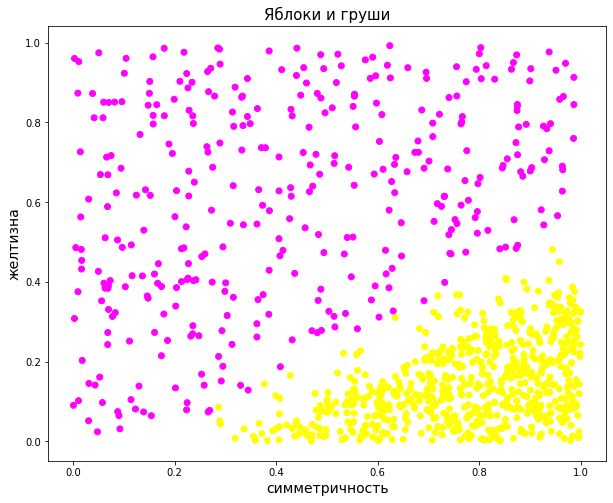

In [ ]:
proba_pred = neuron(X)
y_pred = proba_pred > 0.5
y_pred = y_pred.data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

---

### Задача 1

1. Как видно по рисунку - качество не идеальное (даже перцептрон на нумпае лучше :). Добейтесь идеального качества (или очень близкого к идеальному), путём изменения `learning_rate` и количества итераций (возможно, ещё функции потерь и функции активации);
2. Используйте функцию потерь `torch.nn.NLLLoss()` (== LogLoss) или `torch.nn.CrossEntropy()`, сделайте вывод о работе нейрона.

In [6]:
import torch

In [ ]:
one_hot = pd.get_dummies(data['target'])
data = data.join(one_hot)
data

,yellowness,symmetry,target,0.0,1.0
0,0.779427,0.257305,1.0,0,1
1,0.777005,0.015915,1.0,0,1
2,0.977092,0.304210,1.0,0,1
3,0.043032,0.140899,0.0,1,0
4,0.760433,0.193123,1.0,0,1
...,...,...,...,...,...
995,0.288482,0.051186,0.0,1,0
996,0.892424,0.795257,0.0,1,0
997,0.927219,0.134986,1.0,0,1
998,0.015830,0.481322,0.0,1,0


In [ ]:
X = data.iloc[:,:2].values  # матрица объекты-признаки
y = data.iloc[:,3].values  # классы 

In [7]:
num_features = X.shape[1]
neuron = torch.nn.Sequential(
    torch.nn.Linear(in_features=num_features, out_features = 2),
    torch.nn.Softmax()
)

In [8]:
X = torch.FloatTensor(X).requires_grad_(requires_grad = True)
y = torch.LongTensor(y)

In [ ]:
y_pred = neuron(X)
y_pred.shape

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


torch.Size([1000, 2])

In [ ]:
loss_fn = torch.nn.NLLLoss(reduction='sum')
loss = loss_fn(y_pred, y.view(-1))
loss

tensor(-526.4135, grad_fn=<NllLossBackward0>)

In [9]:
loss_fn = torch.nn.NLLLoss(reduction='sum')
optimizer = torch.optim.Adam(neuron.parameters(), lr = 0.01)

num_epochs = 10000
for i in range(num_epochs):
  y_pred = neuron(X)
  loss = loss_fn(y_pred, y.view(-1))
  print('{} {}'.format(i, loss.data))

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Streaming output truncated to the last 5000 lines.
2152 -939.85546875
2153 -939.8717041015625
2154 -939.887939453125
2155 -939.9041137695312
2156 -939.9203491210938
2157 -939.9366455078125
2158 -939.9527587890625
2159 -939.9689331054688
2160 -939.985107421875
2161 -940.0014038085938
2162 -940.0175170898438
2163 -940.0335693359375
2164 -940.0497436523438
2165 -940.0658569335938
2166 -940.08203125
2167 -940.09814453125
2168 -940.1141967773438
2169 -940.1301879882812
2170 -940.146240234375
2171 -940.1624145507812
2172 -940.178466796875
2173 -940.1944580078125
2174 -940.2105102539062
2175 -940.2265625
2176 -940.2425537109375
2177 -940.258544921875
2178 -940.2745361328125
2179 -940.29052734375
2180 -940.3065185546875
2181 -940.3224487304688
2182 -940.3383178710938
2183 -940.3543090820312
2184 -940.3702392578125
2185 -940.3861083984375
2186 -940.402099609375
2187 -940.4179077148438
2188 -940.433837890625
2189 -940.44970703125
2190 -940.465576171875
2191 -940.4814453125
2192 -940.497253417968

KeyboardInterrupt: ignored

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


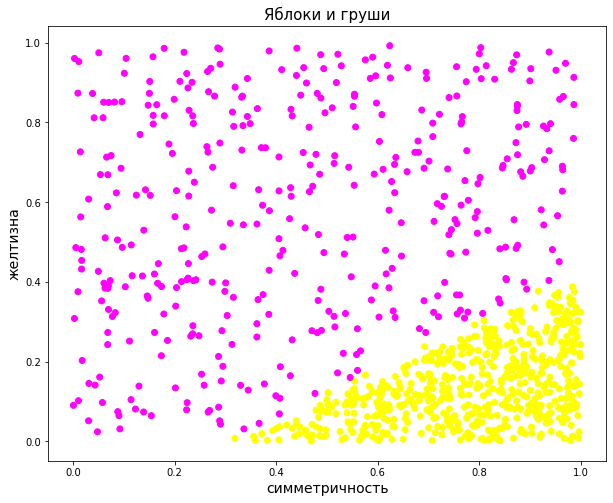

In [ ]:
proba_pred = neuron(X)
y_pred = proba_pred > 0.5
y_pred = y_pred[:,0].data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

In [59]:
X = data.iloc[:,:2].values  # матрица объекты-признаки
y = data['target'].values.reshape((-1, 1))  # классы 

In [60]:
num_feachers = X.shape[1]
neuron = torch.nn.Sequential(
    torch.nn.Linear(in_features=num_features, out_features=1),
    torch.nn.Sigmoid()
)

neuron

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

In [61]:
X = torch.FloatTensor(X).requires_grad_(requires_grad = True)
y = torch.FloatTensor(y).view(-1,2)
#y = torch.FloatTensor(y).view(-1)
y.shape

torch.Size([500, 2])

In [62]:
num_epochs = 10000
loss_fn = torch.nn.CrossEntropyLoss(reduction = 'sum')
optimizer = torch.optim.Adam(neuron.parameters(), lr=0.01)

for i in range(num_epochs):
  y_pred = neuron(X)
  loss = loss_fn(y_pred.view(-1,2), y) # N=500, Classes = 2, containing class probabilities
  #loss = loss_fn(y_pred.view(-1), y)  Classes = 1000
  print('{} {}'.format(i, loss.data))

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Streaming output truncated to the last 5000 lines.
5000 326.7131042480469
5001 326.7117614746094
5002 326.71051025390625
5003 326.7091979980469
5004 326.7079162597656
5005 326.7066345214844
5006 326.7053527832031
5007 326.70404052734375
5008 326.7027587890625
5009 326.70147705078125
5010 326.7001953125
5011 326.6988830566406
5012 326.6976318359375
5013 326.6963195800781
5014 326.69500732421875
5015 326.6937255859375
5016 326.69244384765625
5017 326.6911315917969
5018 326.68988037109375
5019 326.6885986328125
5020 326.6872863769531
5021 326.6860046386719
5022 326.6846923828125
5023 326.6834411621094
5024 326.6821594238281
5025 326.68084716796875
5026 326.6795959472656
5027 326.6783142089844
5028 326.677001953125
5029 326.67572021484375
5030 326.6744384765625
5031 326.67315673828125
5032 326.671875
5033 326.67059326171875
5034 326.6693420410156
5035 326.6680603027344
5036 326.666748046875
5037 326.6654968261719
5038 326.6641845703125
5039 326.6629333496094
5040 326.66162109375
5041 326.6

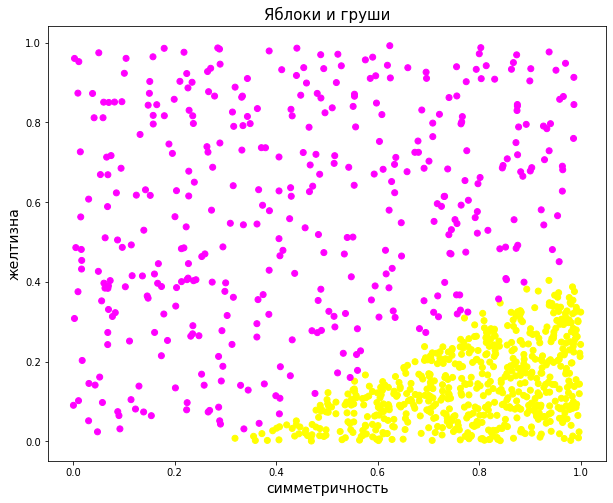

In [63]:
proba_pred = neuron(X)
y_pred = proba_pred > 0.5
y_pred = y_pred.data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

Круто. Нейрон работет, отличает яблоки от груш (Вы ведь этого добились, правда?). Но так ли он силён? Давайте попробуем более сложную выборку, которая уже не разделяется линейно:

In [64]:
import numpy as np

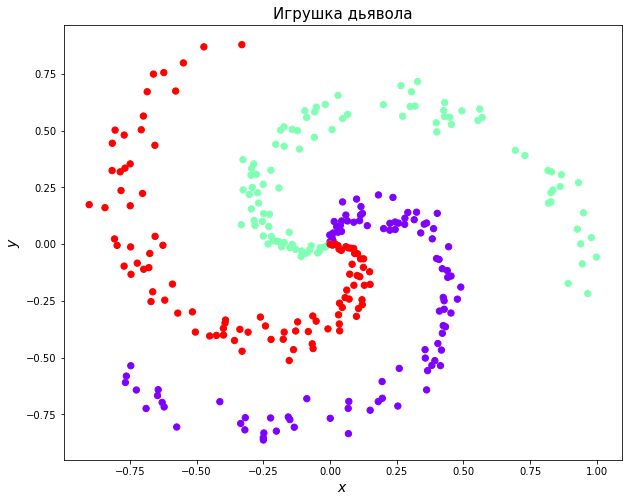

In [65]:
# код для генерации взят из Стэнфордсокго курса:
# http://cs231n.github.io/neural-networks-case-study/#linear

N = 100
D = 2
K = 3
X = np.zeros((N * K, D))
y = np.zeros(N * K, dtype='uint8')

for j in range(K):
    ix = range(N * j,N * (j + 1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j * 4, (j + 1) * 4,N) + np.random.randn(N) * 0.2 # theta
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j

plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)
plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

In [66]:
X = torch.FloatTensor(X).requires_grad_(requires_grad = True)
y = torch.LongTensor(y.astype(np.int64))

In [67]:
print(X.data.shape, y.data.shape)

torch.Size([300, 2]) torch.Size([300])


В атаку, наш славный нейрон с сигмоидой (точнее в данном случае это уже 3 нейрона с софтмаксом):

In [68]:
# пример взят из официального туториала: 
# https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

# N - размер батча (batch_size, нужно для метода оптимизации); 
# D_in - размерность входа (количество признаков у объекта);
# D_out - размерность выходного слоя (суть - количество классов)
N, D_in, D_out = 64, 2, 3

neuron = torch.nn.Sequential(
    torch.nn.Linear(D_in, D_out),
    torch.nn.Sigmoid()
)

loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')

learning_rate = 1e-4
optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)
num_epochs = 10000
for t in range(num_epochs):
    # forward
    y_pred = neuron(X)

    # loss
    loss = loss_fn(y_pred, y)
    print('{} {}'.format(t, loss.data))

    # ЗАНУЛЯЕМ!
    optimizer.zero_grad()

    # backward
    loss.backward()

    # ОБНОВЛЯЕМ! 
    optimizer.step()

Streaming output truncated to the last 5000 lines.
5000 288.2381896972656
5001 288.23541259765625
5002 288.2325744628906
5003 288.2297058105469
5004 288.2268981933594
5005 288.2240905761719
5006 288.2212829589844
5007 288.21844482421875
5008 288.2156066894531
5009 288.2127685546875
5010 288.2099914550781
5011 288.2071533203125
5012 288.204345703125
5013 288.2015380859375
5014 288.1986999511719
5015 288.1959228515625
5016 288.19305419921875
5017 288.19024658203125
5018 288.18743896484375
5019 288.18463134765625
5020 288.1817932128906
5021 288.17901611328125
5022 288.1761474609375
5023 288.1733703613281
5024 288.1705322265625
5025 288.1677551269531
5026 288.1649169921875
5027 288.1621398925781
5028 288.1593322753906
5029 288.1565246582031
5030 288.1537170410156
5031 288.1509094238281
5032 288.1480712890625
5033 288.14532470703125
5034 288.1424865722656
5035 288.13970947265625
5036 288.13690185546875
5037 288.1341247558594
5038 288.1313171386719
5039 288.1285095214844
5040 288.12570190429

In [69]:
# Обратно в Numpy для отрисовки
X = X.data.numpy()
y = y.data.numpy()

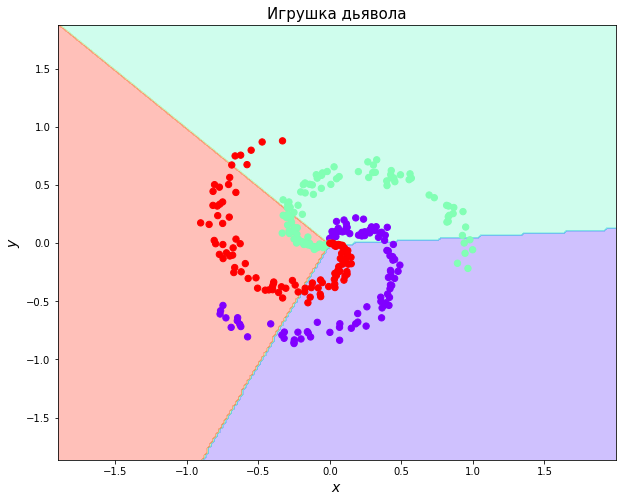

In [70]:
# Отрисовочна магия, снова взято из:
# http://cs231n.github.io/neural-networks-case-study/#linear

h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

Z = neuron(torch.autograd.Variable(grid_tensor))
Z = Z.data.numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

---

### Задача 2

Меняя все известные Вам способы улучшения нейросети, постарайтесь добиться лучшего качества здесь. (**архитектуру менять нельзя**, мы же хотим добиться победы одним нейроном (слоем)).

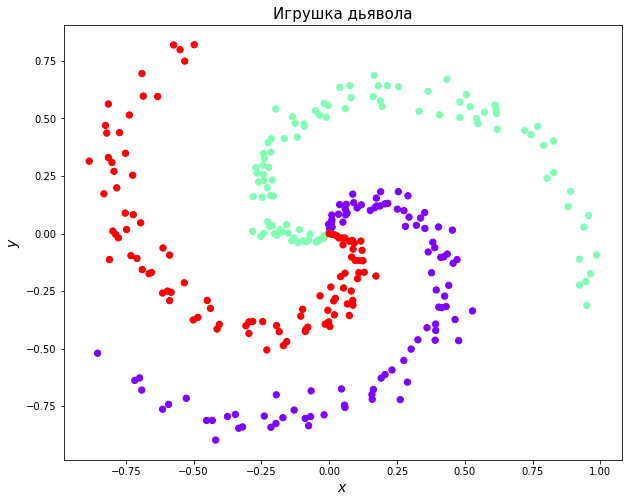

In [259]:
# код для генерации взят из Стэнфордсокго курса:
# http://cs231n.github.io/neural-networks-case-study/#linear

N = 100
D = 2
K = 3
X = np.zeros((N * K, D))
y = np.zeros(N * K, dtype='uint8')

for j in range(K):
    ix = range(N * j,N * (j + 1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j * 4, (j + 1) * 4,N) + np.random.randn(N) * 0.2 # theta
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j

plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)
plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

In [260]:
X = torch.FloatTensor(X).requires_grad_(requires_grad = True)
y = torch.LongTensor(y.astype(np.int64))

In [261]:
# N - размер батча (batch_size, нужно для метода оптимизации); 
# D_in - размерность входа (количество признаков у объекта);
# D_out - размерность выходного слоя (суть - количество классов)
N, D_in, D_out = 32, 2, 3

neuron = torch.nn.Sequential(
    #torch.nn.BatchNorm1d(D_in),
    torch.nn.Linear(D_in, D_out),
    torch.nn.Softmax()
)
neuron

Sequential(
  (0): Linear(in_features=2, out_features=3, bias=True)
  (1): Softmax(dim=None)
)

In [262]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')

learning_rate = 1
optimizer = torch.optim.Adam(neuron.parameters(), lr = learning_rate)

num_epochs = 300000
lambda_group = lambda num_epochs: 0.01 if (num_epochs < 6000) else 0.001
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda_group], verbose=False)

for t in range(num_epochs):

    y_pred = neuron(X)
    loss = loss_fn(y_pred, y) # containing class indices
    print('{} {}'.format(t, loss.data))

    optimizer.zero_grad()
    loss.backward() 
    optimizer.step()
    scheduler.step()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Streaming output truncated to the last 5000 lines.
295000 257.0643310546875
295001 257.0643310546875
295002 257.0643310546875
295003 257.0643005371094
295004 257.0643615722656
295005 257.0643005371094
295006 257.0643005371094
295007 257.0643310546875
295008 257.0643310546875
295009 257.0643310546875
295010 257.0643310546875
295011 257.0643005371094
295012 257.0643005371094
295013 257.0643005371094
295014 257.0643310546875
295015 257.0643005371094
295016 257.0643310546875
295017 257.0643310546875
295018 257.0643310546875
295019 257.0643005371094
295020 257.0643005371094
295021 257.0643005371094
295022 257.0643005371094
295023 257.0643005371094
295024 257.0643005371094
295025 257.0643005371094
295026 257.0643005371094
295027 257.06427001953125
295028 257.0643005371094
295029 257.0643005371094
295030 257.0643005371094
295031 257.0643005371094
295032 257.0643005371094
295033 257.06427001953125
295034 257.06427001953125
295035 257.06427001953125
295036 257.0643005371094
295037 257.064270019

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


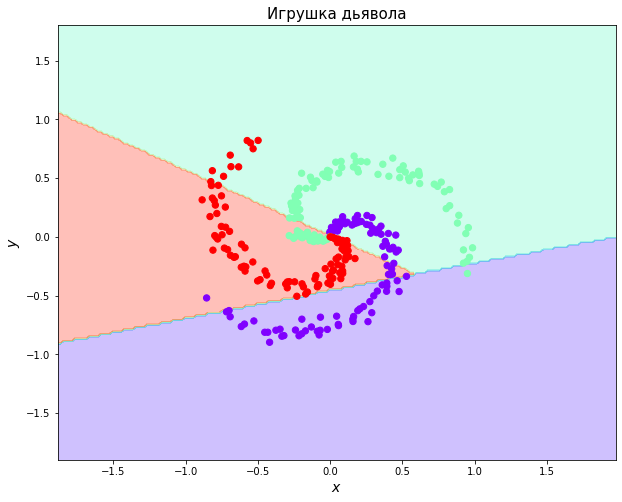

In [263]:
# Отрисовочна магия, снова взято из:
# http://cs231n.github.io/neural-networks-case-study/#linear

X = X.data.numpy()
y = y.data.numpy()

h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

Z = neuron(torch.autograd.Variable(grid_tensor))
Z = Z.data.numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

---

<h3 style="text-align: center;"><b>Полезные ссылки</b></h3>

1). *Примеры написания нейросетей на PyTorch (офийиальные туториалы) (на английском): https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#examples  
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html*

2). ***Один из самых подробных и полных курсов по deep learning на данный момент - это курс Стэнфордского Университета (он вообще сейчас один из лидеров в области ИИ, его выпускники работают в Google, Facebook, Amazon, Microsoft, в стартапах в Кремниевой долине):  http://cs231n.github.io/***  

3). Практически исчерпывающая информация по основам нейросетей (из cs231n) (на английском):  

http://cs231n.github.io/neural-networks-1/,  
http://cs231n.github.io/neural-networks-2/,  
http://cs231n.github.io/neural-networks-3/,  
http://cs231n.github.io/neural-networks-case-study/#linear

4). *Хорошие статьи по основам нейросетей (на английском):  http://neuralnetworksanddeeplearning.com/chap1.html*

5). *Наглядная демонстрация того, как обучаются нейросети:  https://cs.stanford.edu/people/karpathy/convnetjs/*